# Validate Gradient CIP

For validate gradient it is used the model shown below:

$y = W X + c = a x_1 + b x_2 + c$

a simple Neural Network

In [1]:
import theano.tensor as T
from theano import config, shared
import numpy as np

a = 0.2 
b = 0.8
c = 0.1
N = 2000
s_noise = 0.2

x0 = np.linspace(-3.0, 3.0, num=N);
x1 = np.sin(0.5 * x0)
x2 = np.cos(3 * x0)

X = np.array([x1, x2]).T
y = a * x1 + b *x2 + c

nu = np.random.randn(N,) * s_noise

z = y + nu

z = z[:,np.newaxis]

y_str = '$f(x)={%g sin(0.5x)} + {%g cos(3x)} + {%g} = {%g x_1} + {%g x_2} + {%g}$' % (a, b, c, a, b, c)

## Plot data

<IPython.core.display.Javascript object>


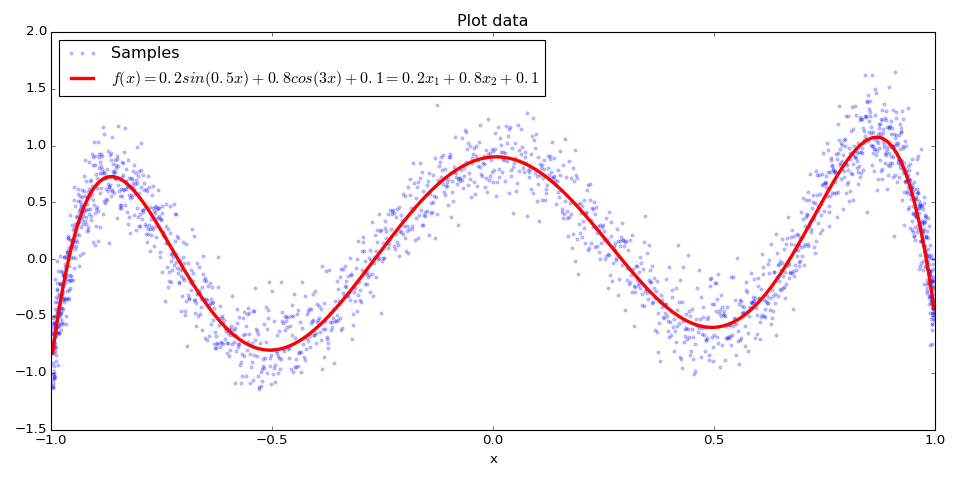

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=80)
ax = plt.subplot()
ax.plot(X[:,0], z, 'b.', alpha=0.25, label='Samples')
ax.plot(X[:,0], y, '-r', lw=3, label=y_str)
plt.title('Plot data')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()


## Define Neural Network

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.metrics import *
from deepensemble.utils import *

from collections import OrderedDict

config.optimizer = 'None'
config.exception_verbosity = 'high'

# Silverman
sigma = ITLFunctions.silverman(z).eval()

print("Silverman: %g" % sigma)

# Create MLP
mlp = Sequential("MLP")  # by default is a regressor
mlp.add_layer(Dense(n_input=X.shape[1], n_output=1, activation=ActivationFunctions.linear))
mlp.append_cost(cip_relevancy, name='Relevancy', s=sigma, dist='ED')
# mlp.append_score(mutual_information_parzen, name='Mutual Information')

Silverman: 0.140467


## Define new update function.

This function uses a gradient computed independent of Library Deep Ensemble.

In [4]:
def d_kernel(dx, s):
    kernel = ITLFunctions.kernel_gauss_diff
    return T.squeeze(T.transpose(T.tile(-kernel(dx, s), (1,), dx.ndim)) * dx / (T.power(s, dx.shape[-1])))

In [5]:
def get_grad_cip(model, s=0.1):
    
    # Gets inputs and outputs model
    x = model.get_model_input()
    y = model.get_model_target()
    o = model.output(x)
    
    # Gets all differents among elements each one 
    DY = ITLFunctions.get_diff([y])[0]
    DX = ITLFunctions.get_diff([o])[0]
    dx = ITLFunctions.get_diff([x])[0]
    
    # Compute sigma or size of kernel
    s = np.sqrt(2) * s

    # Compute of Gradient of Cross Information Potential
    kernel = ITLFunctions.kernel_gauss_diff
    
    DYK = T.transpose(T.tile(kernel(DY, s), (1,), dx.ndim))
    dK = d_kernel(DX, s)
    DDXK = T.tile(dK, (dx.shape[-1],)) * dx

    DV_J = T.mean(DYK * DDXK, axis=(0, 1))

    DV_k_i = [T.mean(DYK, axis=1), T.mean(DDXK, axis=1)]

    DV_k = [T.mean(DV_i, axis=0) for DV_i in DV_k_i]

    DV_M = np.prod(DV_k)

    DV_nc = T.mean(np.prod(DV_k_i))
    
    gradW = (DV_J - 2 * DV_nc + DV_M)
    
    DYK = T.transpose(T.tile(kernel(DY, s), (1,), DX.ndim))
    DDXK = dK

    DV_J = T.mean(DYK * DDXK)

    DV_k_i = [T.mean(DYK, axis=-1), T.mean(DDXK, axis=(-2, -1))]

    DV_k = [T.mean(DV_i) for DV_i in DV_k_i]

    DV_M = np.prod(DV_k)

    DV_nc = T.mean(np.prod(DV_k_i))
    
    gradb = (DV_J - 2 * DV_nc + DV_M)

    return gradW, gradb

## Compare gradient computed with y without using library 

In [6]:
mlp.compile()  # this is necessary for defining input and output model

# Get gradient CIP without DeepEnsemble library
gradW1, gradb1 = get_grad_cip(mlp, s=sigma)

# Get gradient CIP from DeepEnsemble library
cost = mlp.get_cost()
gparams = [T.grad(cost, param) for param in mlp.get_params(only_values=True)]

gradW2 = gparams[0]
gradb2 = gparams[1]

Start Compile MLP  - elapsed: 0.87 [s]


In [7]:
from theano import function

# Define input and output from mlp model
x = mlp.get_model_input()
y = mlp.get_model_target()

# Define function for compute gradients 
fn_gradW1 = function([x, y], gradW1)
fn_gradW2 = function([x, y], gradW2)
fn_gradb1 = function([x, y], gradb1)
fn_gradb2 = function([x, y], gradb2)

# Compute gradients
print(fn_gradW1(X, z), fn_gradb1(X, z))
print(fn_gradW2(X, z), fn_gradb2(X, z))

[ 0.03875179 -0.02199001] 0.005519316216879851
[[-0.02752874]
 [ 0.11190704]] [ -5.62158826e-17]


In [20]:
kernel = ITLFunctions.kernel_gauss_diff
o = mlp.output(X)
DY = ITLFunctions.get_diff([z])[0]
DX = ITLFunctions.get_diff([o])[0]
dx = ITLFunctions.get_diff([X])[0]

s = np.sqrt(2) * sigma

DYK = T.transpose(T.tile(kernel(DY, s), (1,), dx.ndim))
dK = d_kernel(DX, s)
DDXK = T.tile(dK, (dx.shape[-1],)) * dx

DV_J = T.mean(DYK * DDXK, axis=(0, 1))

DV_k_i = [T.mean(DYK, axis=1), T.mean(DDXK, axis=1)]

DV_k = [T.mean(DV_i, axis=0) for DV_i in DV_k_i]

DV_M = np.prod(DV_k)

DV_nc = T.mean(np.prod(DV_k_i))

gradW = (DV_J - 2 * DV_nc + DV_M)

In [21]:
gradW.eval()

array([ 0.03875179, -0.02199001])

In [35]:
DYK = T.transpose(T.tile(kernel(DY, s), (1,), DX.ndim))
DDXK = d_kernel(DX, s)

DV_J = T.mean(DYK * DDXK)

DV_k_i = [T.mean(DYK, axis=-1), T.mean(DDXK, axis=-1)]

DV_k = [T.mean(DV_i) for DV_i in DV_k_i]

DV_M = np.prod(DV_k)

DV_nc = T.mean(np.prod(DV_k_i))

gradb = (DV_J - 2 * DV_nc + DV_M)

In [36]:
T.mean(DDXK, axis=(1, 2)).shape.eval()

array([2000])

In [37]:
DYK.shape.eval()

array([2000, 2000,    1])

In [38]:
gradb.eval()

array(1.5330500823369116e-15)